# Autoencoder untuk Deteksi Penyakit Tanaman Kentang

Proyek ini menggunakan Autoencoder berbasis PyTorch untuk mendeteksi anomali (penyakit) pada daun kentang dengan melatih model hanya pada gambar sehat dan menghitung reconstruction error untuk deteksi anomali.

## 1. Import Libraries dan Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set seed untuk reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


## 2. Data Loading dengan Augmentasi

In [2]:
def load_datasets(data_dir, batch_size=32, val_split=0.2):
    """
    Load dataset dengan augmentasi on-the-fly untuk training.
    
    Args:
        data_dir: Path ke folder dataset
        batch_size: Ukuran batch
        val_split: Proporsi data untuk validasi
    
    Returns:
        train_loader, val_loader, test_loader
    """
    # Transformasi untuk training (dengan augmentasi)
    train_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),  # Konversi ke [0,1]
    ])
    
    # Transformasi untuk validation dan test (tanpa augmentasi)
    test_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    
    # Load hanya folder Healthy untuk training
    healthy_dir = Path(data_dir) / "Potato___healthy"
    healthy_dataset = datasets.ImageFolder(
        root=healthy_dir.parent,
        transform=train_transform
    )
    
    # Filter hanya kelas healthy
    healthy_indices = [i for i, (_, label) in enumerate(healthy_dataset.samples) 
                      if 'healthy' in healthy_dataset.samples[i][0].lower()]
    healthy_dataset = torch.utils.data.Subset(healthy_dataset, healthy_indices)
    
    # Split menjadi train dan validation
    train_size = int((1 - val_split) * len(healthy_dataset))
    val_size = len(healthy_dataset) - train_size
    train_dataset, val_dataset_temp = random_split(
        healthy_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Buat validation dataset dengan transform tanpa augmentasi
    val_dataset = datasets.ImageFolder(
        root=Path(data_dir),
        transform=test_transform
    )
    val_indices = [i for i, (_, label) in enumerate(val_dataset.samples) 
                   if 'healthy' in val_dataset.samples[i][0].lower()]
    val_indices = val_indices[-val_size:]  # Ambil sebagian untuk validasi
    val_dataset = torch.utils.data.Subset(val_dataset, val_indices)
    
    # Load seluruh kelas untuk testing
    test_dataset = datasets.ImageFolder(
        root=Path(data_dir),
        transform=test_transform
    )
    
    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                             shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                           shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                            shuffle=False, num_workers=0, pin_memory=True)
    
    print(f"Train set: {len(train_dataset)} images")
    print(f"Validation set: {len(val_dataset)} images")
    print(f"Test set: {len(test_dataset)} images")
    print(f"Test classes: {test_dataset.classes}")
    
    return train_loader, val_loader, test_loader, test_dataset

# Load data
data_dir = r"c:\project\project-ai\Autoencoder\dataset"
train_loader, val_loader, test_loader, test_dataset = load_datasets(
    data_dir, batch_size=32, val_split=0.2
)

Train set: 121 images
Validation set: 31 images
Test set: 2152 images
Test classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


## 3. Arsitektur Autoencoder

In [3]:
class Autoencoder(nn.Module):
    """
    Autoencoder sederhana untuk deteksi anomali.
    Encoder: 3→16→32→64→128
    Decoder: 128→64→32→16→3
    """
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder: Conv2D dengan stride=2, padding=1
        self.encoder = nn.Sequential(
            # 3 -> 16: (128x128 -> 64x64)
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # 16 -> 32: (64x64 -> 32x32)
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # 32 -> 64: (32x32 -> 16x16)
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # 64 -> 128: (16x16 -> 8x8)
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
        )
        
        # Decoder: ConvTranspose2D dengan stride=2, padding=1
        self.decoder = nn.Sequential(
            # 128 -> 64: (8x8 -> 16x16)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            
            # 64 -> 32: (16x16 -> 32x32)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            
            # 32 -> 16: (32x32 -> 64x64)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            
            # 16 -> 3: (64x64 -> 128x128)
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),  # Output ke [0,1]
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

# Inisialisasi model
model = Autoencoder().to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): 

## 4. Training Setup (Loss, Optimizer, Scheduler, Early Stopping)

In [4]:
class EarlyStopping:
    """Early stopping untuk menghentikan training jika val_loss tidak membaik"""
    def __init__(self, patience=7, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

class ModelCheckpoint:
    """Simpan model terbaik berdasarkan validation loss"""
    def __init__(self, filepath, verbose=True):
        self.filepath = filepath
        self.verbose = verbose
        self.best_loss = float('inf')
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'val_loss': val_loss
            }, self.filepath)
            if self.verbose:
                print(f"Model saved with val_loss: {val_loss:.6f}")

# Setup training components
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)
early_stopping = EarlyStopping(patience=7, verbose=True)
model_checkpoint = ModelCheckpoint(
    filepath=r"c:\project\project-ai\Autoencoder\model\best_autoencoder.pth",
    verbose=True
)

print("Training components initialized:")
print(f"- Loss: MSELoss")
print(f"- Optimizer: Adam (lr=1e-3)")
print(f"- Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)")
print(f"- Early Stopping: patience=7")
print(f"- Model Checkpoint: best_autoencoder.pth")

Training components initialized:
- Loss: MSELoss
- Optimizer: Adam (lr=1e-3)
- Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)
- Early Stopping: patience=7
- Model Checkpoint: best_autoencoder.pth


## 5. Fungsi Training dan Validation

In [5]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train untuk satu epoch"""
    model.train()
    running_loss = 0.0
    
    for images, _ in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def validate_epoch(model, val_loader, criterion, device):
    """Validasi untuk satu epoch"""
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for images, _ in tqdm(val_loader, desc="Validation", leave=False):
            images = images.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)
            
            running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(val_loader.dataset)
    return epoch_loss

def train_model(model, train_loader, val_loader, criterion, optimizer, 
                scheduler, early_stopping, model_checkpoint, 
                num_epochs=50, device='cpu'):
    """
    Training loop lengkap dengan tracking
    """
    history = {
        'train_loss': [],
        'val_loss': [],
        'lr': []
    }
    
    print("=" * 70)
    print(f"Starting training for {num_epochs} epochs...")
    print("=" * 70)
    
    for epoch in range(num_epochs):
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        
        # Training
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        
        # Validation
        val_loss = validate_epoch(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        
        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.6f} | "
              f"Val Loss: {val_loss:.6f} | "
              f"LR: {current_lr:.6f}")
        
        # Scheduler step
        scheduler.step(val_loss)
        
        # Model checkpoint
        model_checkpoint(val_loss, model)
        
        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break
    
    print("=" * 70)
    print("Training completed!")
    print("=" * 70)
    
    return history

# Buat folder model jika belum ada
Path(r"c:\project\project-ai\Autoencoder\model").mkdir(parents=True, exist_ok=True)

## 6. Mulai Training

In [6]:
# Mulai training
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    early_stopping=early_stopping,
    model_checkpoint=model_checkpoint,
    num_epochs=200,
    device=device
)

Starting training for 200 epochs...


Epoch [1/200] | Train Loss: 0.046192 | Val Loss: 0.032510 | LR: 0.001000
Model saved with val_loss: 0.032510


Epoch [2/200] | Train Loss: 0.044547 | Val Loss: 0.032266 | LR: 0.001000
Model saved with val_loss: 0.032266


Epoch [3/200] | Train Loss: 0.045367 | Val Loss: 0.031645 | LR: 0.001000
Model saved with val_loss: 0.031645


Epoch [4/200] | Train Loss: 0.044669 | Val Loss: 0.030932 | LR: 0.001000
Model saved with val_loss: 0.030932


Epoch [5/200] | Train Loss: 0.043890 | Val Loss: 0.030098 | LR: 0.001000
Model saved with val_loss: 0.030098


Epoch [6/200] | Train Loss: 0.042738 | Val Loss: 0.028748 | LR: 0.001000
Model saved with val_loss: 0.028748


Epoch [7/200] | Train Loss: 0.040556 | Val Loss: 0.025896 | LR: 0.001000
Model saved with val_loss: 0.025896


Epoch [8/200] | Train Loss: 0.036443 | Val Loss: 0.022364 | LR: 0.001000
Model saved with val_loss: 0.022364


Epoch [9/200] | Train Loss: 0.034425 | Val Loss: 0.021949 | LR: 0.001000
Model saved with val_loss: 0.021949


Epoch [10/200] | Train Loss: 0.032076 | Val Loss: 0.020166 | LR: 0.001000
Model saved with val_loss: 0.020166


Epoch [11/200] | Train Loss: 0.030301 | Val Loss: 0.018957 | LR: 0.001000
Model saved with val_loss: 0.018957


Epoch [12/200] | Train Loss: 0.030004 | Val Loss: 0.018536 | LR: 0.001000
Model saved with val_loss: 0.018536


Epoch [13/200] | Train Loss: 0.027796 | Val Loss: 0.018088 | LR: 0.001000
Model saved with val_loss: 0.018088


Epoch [14/200] | Train Loss: 0.027741 | Val Loss: 0.017099 | LR: 0.001000
Model saved with val_loss: 0.017099


Epoch [15/200] | Train Loss: 0.025705 | Val Loss: 0.016585 | LR: 0.001000
Model saved with val_loss: 0.016585


Epoch [16/200] | Train Loss: 0.025324 | Val Loss: 0.015922 | LR: 0.001000
Model saved with val_loss: 0.015922


Epoch [17/200] | Train Loss: 0.023743 | Val Loss: 0.015194 | LR: 0.001000
Model saved with val_loss: 0.015194


Epoch [18/200] | Train Loss: 0.021799 | Val Loss: 0.014763 | LR: 0.001000
Model saved with val_loss: 0.014763


Epoch [19/200] | Train Loss: 0.020274 | Val Loss: 0.014274 | LR: 0.001000
Model saved with val_loss: 0.014274


Epoch [20/200] | Train Loss: 0.019482 | Val Loss: 0.013875 | LR: 0.001000
Model saved with val_loss: 0.013875


Epoch [21/200] | Train Loss: 0.018109 | Val Loss: 0.012570 | LR: 0.001000
Model saved with val_loss: 0.012570


Epoch [22/200] | Train Loss: 0.017098 | Val Loss: 0.011698 | LR: 0.001000
Model saved with val_loss: 0.011698


Epoch [23/200] | Train Loss: 0.015810 | Val Loss: 0.010848 | LR: 0.001000
Model saved with val_loss: 0.010848


Epoch [24/200] | Train Loss: 0.014918 | Val Loss: 0.010170 | LR: 0.001000
Model saved with val_loss: 0.010170


Epoch [25/200] | Train Loss: 0.014195 | Val Loss: 0.009572 | LR: 0.001000
Model saved with val_loss: 0.009572


Epoch [26/200] | Train Loss: 0.013437 | Val Loss: 0.009064 | LR: 0.001000
Model saved with val_loss: 0.009064


Epoch [27/200] | Train Loss: 0.012527 | Val Loss: 0.008555 | LR: 0.001000
Model saved with val_loss: 0.008555


Epoch [28/200] | Train Loss: 0.012237 | Val Loss: 0.008587 | LR: 0.001000
EarlyStopping counter: 1/7


Epoch [29/200] | Train Loss: 0.011860 | Val Loss: 0.007938 | LR: 0.001000
Model saved with val_loss: 0.007938


Epoch [30/200] | Train Loss: 0.011049 | Val Loss: 0.007666 | LR: 0.001000
Model saved with val_loss: 0.007666


Epoch [31/200] | Train Loss: 0.010997 | Val Loss: 0.007640 | LR: 0.001000
Model saved with val_loss: 0.007640


Epoch [32/200] | Train Loss: 0.010522 | Val Loss: 0.007285 | LR: 0.001000
Model saved with val_loss: 0.007285


Epoch [33/200] | Train Loss: 0.010296 | Val Loss: 0.007195 | LR: 0.001000
Model saved with val_loss: 0.007195


Epoch [34/200] | Train Loss: 0.010175 | Val Loss: 0.007142 | LR: 0.001000
Model saved with val_loss: 0.007142


Epoch [35/200] | Train Loss: 0.010026 | Val Loss: 0.007028 | LR: 0.001000
Model saved with val_loss: 0.007028


Epoch [36/200] | Train Loss: 0.009797 | Val Loss: 0.006683 | LR: 0.001000
Model saved with val_loss: 0.006683


Epoch [37/200] | Train Loss: 0.009534 | Val Loss: 0.006698 | LR: 0.001000
EarlyStopping counter: 1/7


Epoch [38/200] | Train Loss: 0.009348 | Val Loss: 0.006760 | LR: 0.001000
EarlyStopping counter: 2/7


Epoch [39/200] | Train Loss: 0.009389 | Val Loss: 0.006544 | LR: 0.001000
Model saved with val_loss: 0.006544


Epoch [40/200] | Train Loss: 0.009285 | Val Loss: 0.006457 | LR: 0.001000
Model saved with val_loss: 0.006457


Epoch [41/200] | Train Loss: 0.009064 | Val Loss: 0.006427 | LR: 0.001000
Model saved with val_loss: 0.006427


Epoch [42/200] | Train Loss: 0.008893 | Val Loss: 0.006331 | LR: 0.001000
Model saved with val_loss: 0.006331


Epoch [43/200] | Train Loss: 0.008793 | Val Loss: 0.006299 | LR: 0.001000
Model saved with val_loss: 0.006299


Epoch [44/200] | Train Loss: 0.008810 | Val Loss: 0.006221 | LR: 0.001000
Model saved with val_loss: 0.006221


Epoch [45/200] | Train Loss: 0.008634 | Val Loss: 0.006229 | LR: 0.001000
EarlyStopping counter: 1/7


Epoch [46/200] | Train Loss: 0.008545 | Val Loss: 0.006340 | LR: 0.001000
EarlyStopping counter: 2/7


Epoch [47/200] | Train Loss: 0.009679 | Val Loss: 0.006427 | LR: 0.001000
EarlyStopping counter: 3/7


Epoch [48/200] | Train Loss: 0.009125 | Val Loss: 0.007036 | LR: 0.001000
EarlyStopping counter: 4/7


Epoch [49/200] | Train Loss: 0.008959 | Val Loss: 0.006454 | LR: 0.000500
EarlyStopping counter: 5/7


Epoch [50/200] | Train Loss: 0.008661 | Val Loss: 0.006176 | LR: 0.000500
Model saved with val_loss: 0.006176


Epoch [51/200] | Train Loss: 0.008550 | Val Loss: 0.006316 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [52/200] | Train Loss: 0.008571 | Val Loss: 0.006150 | LR: 0.000500
Model saved with val_loss: 0.006150


Epoch [53/200] | Train Loss: 0.008271 | Val Loss: 0.006071 | LR: 0.000500
Model saved with val_loss: 0.006071


Epoch [54/200] | Train Loss: 0.008347 | Val Loss: 0.006068 | LR: 0.000500
Model saved with val_loss: 0.006068


Epoch [55/200] | Train Loss: 0.008308 | Val Loss: 0.005976 | LR: 0.000500
Model saved with val_loss: 0.005976


Epoch [56/200] | Train Loss: 0.008220 | Val Loss: 0.005944 | LR: 0.000500
Model saved with val_loss: 0.005944


Epoch [57/200] | Train Loss: 0.008164 | Val Loss: 0.005963 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [58/200] | Train Loss: 0.008067 | Val Loss: 0.005921 | LR: 0.000500
Model saved with val_loss: 0.005921


Epoch [59/200] | Train Loss: 0.008040 | Val Loss: 0.005889 | LR: 0.000500
Model saved with val_loss: 0.005889


Epoch [60/200] | Train Loss: 0.008006 | Val Loss: 0.005884 | LR: 0.000500
Model saved with val_loss: 0.005884


Epoch [61/200] | Train Loss: 0.007917 | Val Loss: 0.005870 | LR: 0.000500
Model saved with val_loss: 0.005870


Epoch [62/200] | Train Loss: 0.007951 | Val Loss: 0.005846 | LR: 0.000500
Model saved with val_loss: 0.005846


Epoch [63/200] | Train Loss: 0.007928 | Val Loss: 0.005817 | LR: 0.000500
Model saved with val_loss: 0.005817


Epoch [64/200] | Train Loss: 0.007886 | Val Loss: 0.005821 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [65/200] | Train Loss: 0.007879 | Val Loss: 0.005818 | LR: 0.000500
EarlyStopping counter: 2/7


Epoch [66/200] | Train Loss: 0.007898 | Val Loss: 0.005807 | LR: 0.000500
Model saved with val_loss: 0.005807


Epoch [67/200] | Train Loss: 0.007903 | Val Loss: 0.005762 | LR: 0.000500
Model saved with val_loss: 0.005762


Epoch [68/200] | Train Loss: 0.007879 | Val Loss: 0.005761 | LR: 0.000500
Model saved with val_loss: 0.005761


Epoch [69/200] | Train Loss: 0.007767 | Val Loss: 0.005760 | LR: 0.000500
Model saved with val_loss: 0.005760


Epoch [70/200] | Train Loss: 0.007778 | Val Loss: 0.005734 | LR: 0.000500
Model saved with val_loss: 0.005734


Epoch [71/200] | Train Loss: 0.007774 | Val Loss: 0.005731 | LR: 0.000500
Model saved with val_loss: 0.005731


Epoch [72/200] | Train Loss: 0.007781 | Val Loss: 0.005721 | LR: 0.000500
Model saved with val_loss: 0.005721


Epoch [73/200] | Train Loss: 0.007718 | Val Loss: 0.005694 | LR: 0.000500
Model saved with val_loss: 0.005694


Epoch [74/200] | Train Loss: 0.007650 | Val Loss: 0.005675 | LR: 0.000500
Model saved with val_loss: 0.005675


Epoch [75/200] | Train Loss: 0.007546 | Val Loss: 0.005650 | LR: 0.000500
Model saved with val_loss: 0.005650


Epoch [76/200] | Train Loss: 0.007611 | Val Loss: 0.005654 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [77/200] | Train Loss: 0.007505 | Val Loss: 0.005630 | LR: 0.000500
Model saved with val_loss: 0.005630


Epoch [78/200] | Train Loss: 0.007499 | Val Loss: 0.005620 | LR: 0.000500
Model saved with val_loss: 0.005620


Epoch [79/200] | Train Loss: 0.007515 | Val Loss: 0.005601 | LR: 0.000500
Model saved with val_loss: 0.005601


Epoch [80/200] | Train Loss: 0.007489 | Val Loss: 0.005572 | LR: 0.000500
Model saved with val_loss: 0.005572


Epoch [81/200] | Train Loss: 0.007436 | Val Loss: 0.005549 | LR: 0.000500
Model saved with val_loss: 0.005549


Epoch [82/200] | Train Loss: 0.007467 | Val Loss: 0.005574 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [83/200] | Train Loss: 0.007348 | Val Loss: 0.005544 | LR: 0.000500
Model saved with val_loss: 0.005544


Epoch [84/200] | Train Loss: 0.007378 | Val Loss: 0.005517 | LR: 0.000500
Model saved with val_loss: 0.005517


Epoch [85/200] | Train Loss: 0.007336 | Val Loss: 0.005516 | LR: 0.000500
Model saved with val_loss: 0.005516


Epoch [86/200] | Train Loss: 0.007381 | Val Loss: 0.005494 | LR: 0.000500
Model saved with val_loss: 0.005494


Epoch [87/200] | Train Loss: 0.007321 | Val Loss: 0.005487 | LR: 0.000500
Model saved with val_loss: 0.005487


Epoch [88/200] | Train Loss: 0.007227 | Val Loss: 0.005451 | LR: 0.000500
Model saved with val_loss: 0.005451


Epoch [89/200] | Train Loss: 0.007241 | Val Loss: 0.005457 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [90/200] | Train Loss: 0.007213 | Val Loss: 0.005454 | LR: 0.000500
EarlyStopping counter: 2/7


Epoch [91/200] | Train Loss: 0.007138 | Val Loss: 0.005433 | LR: 0.000500
Model saved with val_loss: 0.005433


Epoch [92/200] | Train Loss: 0.007067 | Val Loss: 0.005398 | LR: 0.000500
Model saved with val_loss: 0.005398


Epoch [93/200] | Train Loss: 0.007149 | Val Loss: 0.005398 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [94/200] | Train Loss: 0.007107 | Val Loss: 0.005359 | LR: 0.000500
Model saved with val_loss: 0.005359


Epoch [95/200] | Train Loss: 0.007077 | Val Loss: 0.005374 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [96/200] | Train Loss: 0.007039 | Val Loss: 0.005322 | LR: 0.000500
Model saved with val_loss: 0.005322


Epoch [97/200] | Train Loss: 0.006986 | Val Loss: 0.005309 | LR: 0.000500
Model saved with val_loss: 0.005309


Epoch [98/200] | Train Loss: 0.007007 | Val Loss: 0.005308 | LR: 0.000500
Model saved with val_loss: 0.005308


Epoch [99/200] | Train Loss: 0.006869 | Val Loss: 0.005268 | LR: 0.000500
Model saved with val_loss: 0.005268


Epoch [100/200] | Train Loss: 0.006934 | Val Loss: 0.005282 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [101/200] | Train Loss: 0.006867 | Val Loss: 0.005243 | LR: 0.000500
Model saved with val_loss: 0.005243


Epoch [102/200] | Train Loss: 0.006836 | Val Loss: 0.005240 | LR: 0.000500
Model saved with val_loss: 0.005240


Epoch [103/200] | Train Loss: 0.006779 | Val Loss: 0.005200 | LR: 0.000500
Model saved with val_loss: 0.005200


Epoch [104/200] | Train Loss: 0.006790 | Val Loss: 0.005195 | LR: 0.000500
Model saved with val_loss: 0.005195


Epoch [105/200] | Train Loss: 0.006760 | Val Loss: 0.005181 | LR: 0.000500
Model saved with val_loss: 0.005181


Epoch [106/200] | Train Loss: 0.006702 | Val Loss: 0.005141 | LR: 0.000500
Model saved with val_loss: 0.005141


Epoch [107/200] | Train Loss: 0.006691 | Val Loss: 0.005125 | LR: 0.000500
Model saved with val_loss: 0.005125


Epoch [108/200] | Train Loss: 0.006610 | Val Loss: 0.005102 | LR: 0.000500
Model saved with val_loss: 0.005102


Epoch [109/200] | Train Loss: 0.006622 | Val Loss: 0.005105 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [110/200] | Train Loss: 0.006590 | Val Loss: 0.005071 | LR: 0.000500
Model saved with val_loss: 0.005071


Epoch [111/200] | Train Loss: 0.006613 | Val Loss: 0.005060 | LR: 0.000500
Model saved with val_loss: 0.005060


Epoch [112/200] | Train Loss: 0.006527 | Val Loss: 0.005013 | LR: 0.000500
Model saved with val_loss: 0.005013


Epoch [113/200] | Train Loss: 0.006468 | Val Loss: 0.005015 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [114/200] | Train Loss: 0.006468 | Val Loss: 0.004991 | LR: 0.000500
Model saved with val_loss: 0.004991


Epoch [115/200] | Train Loss: 0.006467 | Val Loss: 0.005000 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [116/200] | Train Loss: 0.006478 | Val Loss: 0.004954 | LR: 0.000500
Model saved with val_loss: 0.004954


Epoch [117/200] | Train Loss: 0.006437 | Val Loss: 0.004934 | LR: 0.000500
Model saved with val_loss: 0.004934


Epoch [118/200] | Train Loss: 0.006349 | Val Loss: 0.004912 | LR: 0.000500
Model saved with val_loss: 0.004912


Epoch [119/200] | Train Loss: 0.006341 | Val Loss: 0.004904 | LR: 0.000500
Model saved with val_loss: 0.004904


Epoch [120/200] | Train Loss: 0.006344 | Val Loss: 0.004890 | LR: 0.000500
Model saved with val_loss: 0.004890


Epoch [121/200] | Train Loss: 0.006337 | Val Loss: 0.004870 | LR: 0.000500
Model saved with val_loss: 0.004870


Epoch [122/200] | Train Loss: 0.006314 | Val Loss: 0.004856 | LR: 0.000500
Model saved with val_loss: 0.004856


Epoch [123/200] | Train Loss: 0.006285 | Val Loss: 0.004856 | LR: 0.000500
Model saved with val_loss: 0.004856


Epoch [124/200] | Train Loss: 0.006231 | Val Loss: 0.004817 | LR: 0.000500
Model saved with val_loss: 0.004817


Epoch [125/200] | Train Loss: 0.006119 | Val Loss: 0.004792 | LR: 0.000500
Model saved with val_loss: 0.004792


Epoch [126/200] | Train Loss: 0.006159 | Val Loss: 0.004786 | LR: 0.000500
Model saved with val_loss: 0.004786


Epoch [127/200] | Train Loss: 0.006195 | Val Loss: 0.004759 | LR: 0.000500
Model saved with val_loss: 0.004759


Epoch [128/200] | Train Loss: 0.006168 | Val Loss: 0.004749 | LR: 0.000500
Model saved with val_loss: 0.004749


Epoch [129/200] | Train Loss: 0.006127 | Val Loss: 0.004789 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [130/200] | Train Loss: 0.006107 | Val Loss: 0.004721 | LR: 0.000500
Model saved with val_loss: 0.004721


Epoch [131/200] | Train Loss: 0.006075 | Val Loss: 0.004706 | LR: 0.000500
Model saved with val_loss: 0.004706


Epoch [132/200] | Train Loss: 0.006027 | Val Loss: 0.004676 | LR: 0.000500
Model saved with val_loss: 0.004676


Epoch [133/200] | Train Loss: 0.006082 | Val Loss: 0.004764 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [134/200] | Train Loss: 0.006136 | Val Loss: 0.004660 | LR: 0.000500
Model saved with val_loss: 0.004660


Epoch [135/200] | Train Loss: 0.006070 | Val Loss: 0.004641 | LR: 0.000500
Model saved with val_loss: 0.004641


Epoch [136/200] | Train Loss: 0.006038 | Val Loss: 0.004663 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [137/200] | Train Loss: 0.006021 | Val Loss: 0.004632 | LR: 0.000500
Model saved with val_loss: 0.004632


Epoch [138/200] | Train Loss: 0.005974 | Val Loss: 0.004607 | LR: 0.000500
Model saved with val_loss: 0.004607


Epoch [139/200] | Train Loss: 0.005970 | Val Loss: 0.004595 | LR: 0.000500
Model saved with val_loss: 0.004595


Epoch [140/200] | Train Loss: 0.005933 | Val Loss: 0.004583 | LR: 0.000500
Model saved with val_loss: 0.004583


Epoch [141/200] | Train Loss: 0.005888 | Val Loss: 0.004568 | LR: 0.000500
Model saved with val_loss: 0.004568


Epoch [142/200] | Train Loss: 0.005870 | Val Loss: 0.004551 | LR: 0.000500
Model saved with val_loss: 0.004551


Epoch [143/200] | Train Loss: 0.005785 | Val Loss: 0.004543 | LR: 0.000500
Model saved with val_loss: 0.004543


Epoch [144/200] | Train Loss: 0.005782 | Val Loss: 0.004525 | LR: 0.000500
Model saved with val_loss: 0.004525


Epoch [145/200] | Train Loss: 0.005810 | Val Loss: 0.004506 | LR: 0.000500
Model saved with val_loss: 0.004506


Epoch [146/200] | Train Loss: 0.005813 | Val Loss: 0.004498 | LR: 0.000500
Model saved with val_loss: 0.004498


Epoch [147/200] | Train Loss: 0.005732 | Val Loss: 0.004490 | LR: 0.000500
Model saved with val_loss: 0.004490


Epoch [148/200] | Train Loss: 0.005743 | Val Loss: 0.004478 | LR: 0.000500
Model saved with val_loss: 0.004478


Epoch [149/200] | Train Loss: 0.005815 | Val Loss: 0.004514 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [150/200] | Train Loss: 0.005782 | Val Loss: 0.004456 | LR: 0.000500
Model saved with val_loss: 0.004456


Epoch [151/200] | Train Loss: 0.005697 | Val Loss: 0.004470 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [152/200] | Train Loss: 0.005719 | Val Loss: 0.004496 | LR: 0.000500
EarlyStopping counter: 2/7


Epoch [153/200] | Train Loss: 0.005663 | Val Loss: 0.004428 | LR: 0.000500
Model saved with val_loss: 0.004428


Epoch [154/200] | Train Loss: 0.005689 | Val Loss: 0.004437 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [155/200] | Train Loss: 0.005651 | Val Loss: 0.004401 | LR: 0.000500
Model saved with val_loss: 0.004401


Epoch [156/200] | Train Loss: 0.005613 | Val Loss: 0.004395 | LR: 0.000500
Model saved with val_loss: 0.004395


Epoch [157/200] | Train Loss: 0.005587 | Val Loss: 0.004387 | LR: 0.000500
Model saved with val_loss: 0.004387


Epoch [158/200] | Train Loss: 0.005600 | Val Loss: 0.004378 | LR: 0.000500
Model saved with val_loss: 0.004378


Epoch [159/200] | Train Loss: 0.005585 | Val Loss: 0.004370 | LR: 0.000500
Model saved with val_loss: 0.004370


Epoch [160/200] | Train Loss: 0.005545 | Val Loss: 0.004380 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [161/200] | Train Loss: 0.005626 | Val Loss: 0.004355 | LR: 0.000500
Model saved with val_loss: 0.004355


Epoch [162/200] | Train Loss: 0.005511 | Val Loss: 0.004362 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [163/200] | Train Loss: 0.005545 | Val Loss: 0.004366 | LR: 0.000500
EarlyStopping counter: 2/7


Epoch [164/200] | Train Loss: 0.005529 | Val Loss: 0.004304 | LR: 0.000500
Model saved with val_loss: 0.004304


Epoch [165/200] | Train Loss: 0.005505 | Val Loss: 0.004311 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [166/200] | Train Loss: 0.005461 | Val Loss: 0.004293 | LR: 0.000500
Model saved with val_loss: 0.004293


Epoch [167/200] | Train Loss: 0.005451 | Val Loss: 0.004302 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [168/200] | Train Loss: 0.005497 | Val Loss: 0.004374 | LR: 0.000500
EarlyStopping counter: 2/7


Epoch [169/200] | Train Loss: 0.005528 | Val Loss: 0.004293 | LR: 0.000500
EarlyStopping counter: 3/7


Epoch [170/200] | Train Loss: 0.005433 | Val Loss: 0.004272 | LR: 0.000500
Model saved with val_loss: 0.004272


Epoch [171/200] | Train Loss: 0.005391 | Val Loss: 0.004251 | LR: 0.000500
Model saved with val_loss: 0.004251


Epoch [172/200] | Train Loss: 0.005407 | Val Loss: 0.004240 | LR: 0.000500
Model saved with val_loss: 0.004240


Epoch [173/200] | Train Loss: 0.005504 | Val Loss: 0.004545 | LR: 0.000500
EarlyStopping counter: 1/7


Epoch [174/200] | Train Loss: 0.005505 | Val Loss: 0.004369 | LR: 0.000500
EarlyStopping counter: 2/7


Epoch [175/200] | Train Loss: 0.005510 | Val Loss: 0.004276 | LR: 0.000500
EarlyStopping counter: 3/7


Epoch [176/200] | Train Loss: 0.005439 | Val Loss: 0.004282 | LR: 0.000500
EarlyStopping counter: 4/7


Epoch [177/200] | Train Loss: 0.005406 | Val Loss: 0.004240 | LR: 0.000250
EarlyStopping counter: 5/7


Epoch [178/200] | Train Loss: 0.005377 | Val Loss: 0.004206 | LR: 0.000250
Model saved with val_loss: 0.004206


Epoch [179/200] | Train Loss: 0.005381 | Val Loss: 0.004195 | LR: 0.000250
Model saved with val_loss: 0.004195


Epoch [180/200] | Train Loss: 0.005342 | Val Loss: 0.004193 | LR: 0.000250
Model saved with val_loss: 0.004193


Epoch [181/200] | Train Loss: 0.005290 | Val Loss: 0.004194 | LR: 0.000250
EarlyStopping counter: 1/7


Epoch [182/200] | Train Loss: 0.005296 | Val Loss: 0.004184 | LR: 0.000250
Model saved with val_loss: 0.004184


Epoch [183/200] | Train Loss: 0.005265 | Val Loss: 0.004182 | LR: 0.000250
Model saved with val_loss: 0.004182


Epoch [184/200] | Train Loss: 0.005262 | Val Loss: 0.004177 | LR: 0.000250
Model saved with val_loss: 0.004177


Epoch [185/200] | Train Loss: 0.005340 | Val Loss: 0.004173 | LR: 0.000250
Model saved with val_loss: 0.004173


Epoch [186/200] | Train Loss: 0.005274 | Val Loss: 0.004167 | LR: 0.000250
Model saved with val_loss: 0.004167


Epoch [187/200] | Train Loss: 0.005259 | Val Loss: 0.004161 | LR: 0.000250
Model saved with val_loss: 0.004161


Epoch [188/200] | Train Loss: 0.005267 | Val Loss: 0.004158 | LR: 0.000250
Model saved with val_loss: 0.004158


Epoch [189/200] | Train Loss: 0.005275 | Val Loss: 0.004158 | LR: 0.000250
EarlyStopping counter: 1/7


Epoch [190/200] | Train Loss: 0.005259 | Val Loss: 0.004148 | LR: 0.000250
Model saved with val_loss: 0.004148


Epoch [191/200] | Train Loss: 0.005261 | Val Loss: 0.004145 | LR: 0.000250
Model saved with val_loss: 0.004145


Epoch [192/200] | Train Loss: 0.005265 | Val Loss: 0.004142 | LR: 0.000250
Model saved with val_loss: 0.004142


Epoch [193/200] | Train Loss: 0.005227 | Val Loss: 0.004143 | LR: 0.000250
EarlyStopping counter: 1/7


Epoch [194/200] | Train Loss: 0.005252 | Val Loss: 0.004143 | LR: 0.000250
EarlyStopping counter: 2/7


Epoch [195/200] | Train Loss: 0.005210 | Val Loss: 0.004130 | LR: 0.000250
Model saved with val_loss: 0.004130


Epoch [196/200] | Train Loss: 0.005224 | Val Loss: 0.004128 | LR: 0.000250
Model saved with val_loss: 0.004128


Epoch [197/200] | Train Loss: 0.005184 | Val Loss: 0.004121 | LR: 0.000250
Model saved with val_loss: 0.004121


Epoch [198/200] | Train Loss: 0.005229 | Val Loss: 0.004115 | LR: 0.000250
Model saved with val_loss: 0.004115


Epoch [199/200] | Train Loss: 0.005217 | Val Loss: 0.004110 | LR: 0.000250
Model saved with val_loss: 0.004110


Epoch [200/200] | Train Loss: 0.005153 | Val Loss: 0.004109 | LR: 0.000250
Model saved with val_loss: 0.004109
Training completed!


## 7. Visualisasi Learning Curve dan Learning Rate

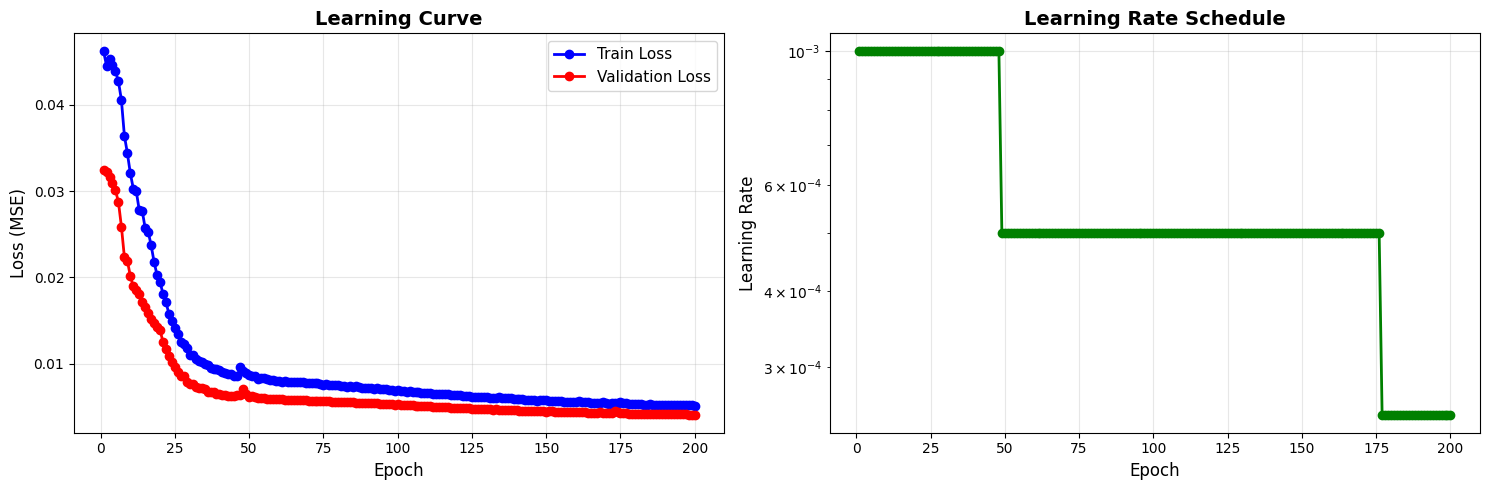


Training Summary:
Best Train Loss: 0.005153
Best Val Loss: 0.004109
Final Learning Rate: 0.000250
Total Epochs: 200


In [7]:
def plot_training_history(history):
    """Visualisasi learning curve dan learning rate"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Learning Curve
    epochs = range(1, len(history['train_loss']) + 1)
    axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-o', label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0].set_title('Learning Curve', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Learning Rate
    axes[1].plot(epochs, history['lr'], 'g-o', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Learning Rate', fontsize=12)
    axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(r'c:\project\project-ai\Autoencoder\model\training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"\n{'='*50}")
    print(f"Training Summary:")
    print(f"{'='*50}")
    print(f"Best Train Loss: {min(history['train_loss']):.6f}")
    print(f"Best Val Loss: {min(history['val_loss']):.6f}")
    print(f"Final Learning Rate: {history['lr'][-1]:.6f}")
    print(f"Total Epochs: {len(history['train_loss'])}")
    print(f"{'='*50}")

plot_training_history(history)

## 8. Load Model Terbaik dan Evaluasi

In [8]:
# Load model terbaik
checkpoint = torch.load(r"c:\project\project-ai\Autoencoder\model\best_autoencoder.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model with validation loss: {checkpoint['val_loss']:.6f}")

def compute_reconstruction_errors(model, test_loader, device):
    """
    Hitung reconstruction error untuk setiap gambar dalam test set
    """
    model.eval()
    all_errors = []
    all_labels = []
    all_images = []
    all_reconstructed = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Computing errors"):
            images = images.to(device)
            reconstructed = model(images)
            
            # Hitung MSE per gambar
            errors = torch.mean((images - reconstructed) ** 2, dim=[1, 2, 3])
            
            all_errors.extend(errors.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_images.append(images.cpu())
            all_reconstructed.append(reconstructed.cpu())
    
    return {
        'errors': np.array(all_errors),
        'labels': np.array(all_labels),
        'images': torch.cat(all_images),
        'reconstructed': torch.cat(all_reconstructed)
    }

# Compute errors
results = compute_reconstruction_errors(model, test_loader, device)
print(f"\nComputed reconstruction errors for {len(results['errors'])} images")

Loaded best model with validation loss: 0.004109


Computing errors: 100%|██████████| 68/68 [00:06<00:00, 10.86it/s]




Computed reconstruction errors for 2152 images


## 9. Analisis Reconstruction Error per Kelas

In [9]:
def analyze_errors_by_class(results, class_names):
    """
    Analisis reconstruction error berdasarkan kelas
    """
    errors = results['errors']
    labels = results['labels']
    
    print(f"\n{'='*70}")
    print(f"Reconstruction Error Statistics by Class")
    print(f"{'='*70}")
    
    for i, class_name in enumerate(class_names):
        class_errors = errors[labels == i]
        print(f"\n{class_name}:")
        print(f"  Count: {len(class_errors)}")
        print(f"  Mean: {np.mean(class_errors):.6f}")
        print(f"  Std: {np.std(class_errors):.6f}")
        print(f"  Min: {np.min(class_errors):.6f}")
        print(f"  Max: {np.max(class_errors):.6f}")
        print(f"  Median: {np.median(class_errors):.6f}")
    
    print(f"\n{'='*70}")
    
    # Hitung threshold untuk anomaly detection
    # Asumsi: healthy adalah class 1 (Potato___healthy)
    healthy_errors = errors[labels == 1]
    threshold = np.mean(healthy_errors) + 2 * np.std(healthy_errors)
    
    print(f"\nAnomaly Detection Threshold (mean + 2*std dari healthy): {threshold:.6f}")
    
    # Klasifikasi menggunakan threshold
    predictions = (errors > threshold).astype(int)  # 1 = anomaly, 0 = normal
    ground_truth = (labels != 1).astype(int)  # 1 = diseased, 0 = healthy
    
    # Hitung metrik
    from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
    
    print(f"\n{'='*70}")
    print(f"Classification Results (Normal vs Anomaly)")
    print(f"{'='*70}")
    print(f"\nAccuracy: {accuracy_score(ground_truth, predictions):.4f}")
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(ground_truth, predictions)
    print(cm)
    print(f"\nClassification Report:")
    print(classification_report(ground_truth, predictions, 
                                target_names=['Healthy', 'Diseased']))
    
    return threshold

# Analisis errors
class_names = test_dataset.classes
threshold = analyze_errors_by_class(results, class_names)


Reconstruction Error Statistics by Class

Potato___Early_blight:
  Count: 1000
  Mean: 0.008940
  Std: 0.003379
  Min: 0.003459
  Max: 0.022803
  Median: 0.007791

Potato___Late_blight:
  Count: 1000
  Mean: 0.004483
  Std: 0.001281
  Min: 0.002184
  Max: 0.010008
  Median: 0.004352

Potato___healthy:
  Count: 152
  Mean: 0.004069
  Std: 0.000810
  Min: 0.002194
  Max: 0.006448
  Median: 0.003995


Anomaly Detection Threshold (mean + 2*std dari healthy): 0.007045

Classification Results (Normal vs Anomaly)

Accuracy: 0.7398

Confusion Matrix:
[[964  36]
 [524 628]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.65      0.96      0.77      1000
    Diseased       0.95      0.55      0.69      1152

    accuracy                           0.74      2152
   macro avg       0.80      0.75      0.73      2152
weighted avg       0.81      0.74      0.73      2152


Classification Results (Normal vs Anomaly)

Accuracy: 0.7398

Confusion Mat

## 10. Visualisasi Distribusi Reconstruction Error

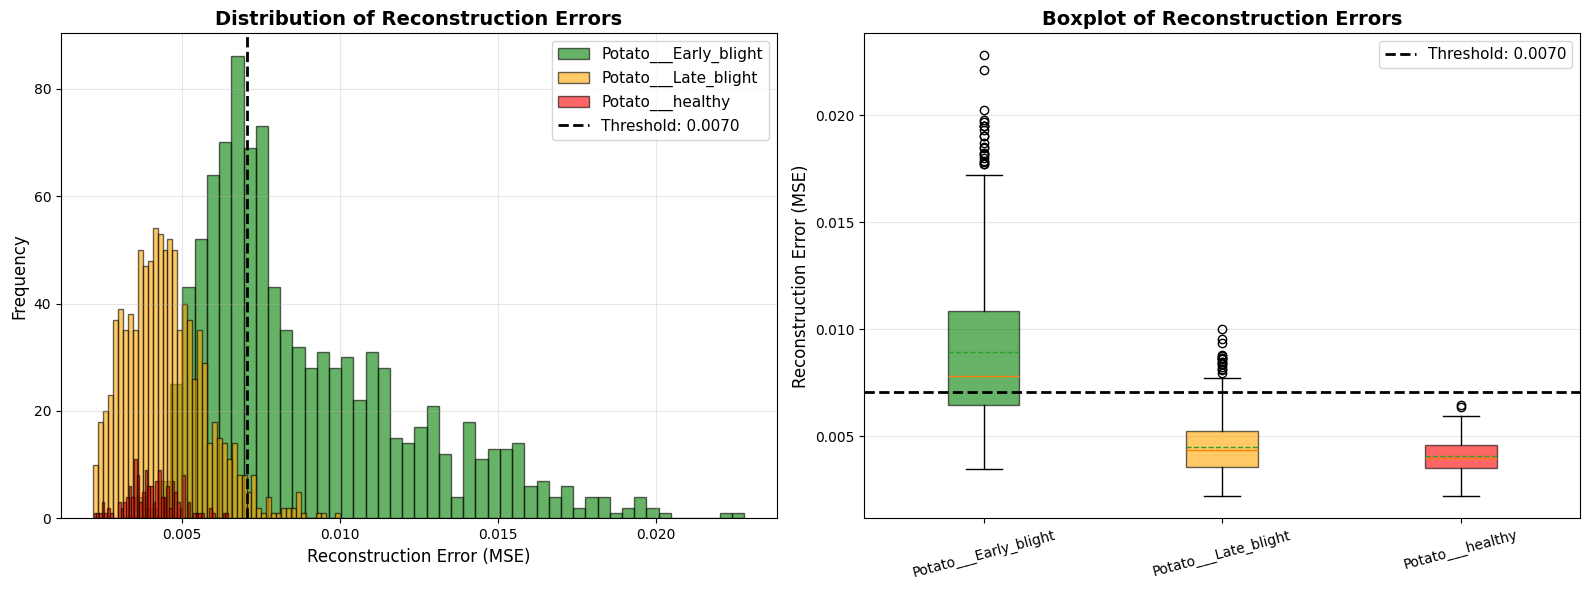

In [10]:
def plot_error_distribution(results, class_names, threshold):
    """
    Visualisasi distribusi reconstruction error
    """
    errors = results['errors']
    labels = results['labels']
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Histogram
    colors = ['green', 'orange', 'red']
    for i, class_name in enumerate(class_names):
        class_errors = errors[labels == i]
        axes[0].hist(class_errors, bins=50, alpha=0.6, label=class_name, 
                    color=colors[i], edgecolor='black')
    
    axes[0].axvline(threshold, color='black', linestyle='--', linewidth=2, 
                   label=f'Threshold: {threshold:.4f}')
    axes[0].set_xlabel('Reconstruction Error (MSE)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Distribution of Reconstruction Errors', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Boxplot
    data_for_box = [errors[labels == i] for i in range(len(class_names))]
    bp = axes[1].boxplot(data_for_box, labels=class_names, patch_artist=True,
                         showmeans=True, meanline=True)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    axes[1].axhline(threshold, color='black', linestyle='--', linewidth=2, 
                   label=f'Threshold: {threshold:.4f}')
    axes[1].set_ylabel('Reconstruction Error (MSE)', fontsize=12)
    axes[1].set_title('Boxplot of Reconstruction Errors', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=15)
    
    plt.tight_layout()
    plt.savefig(r'c:\project\project-ai\Autoencoder\model\error_distribution.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

plot_error_distribution(results, class_names, threshold)

## 11. Visualisasi Rekonstruksi: Daun Sehat vs Berpenyakit

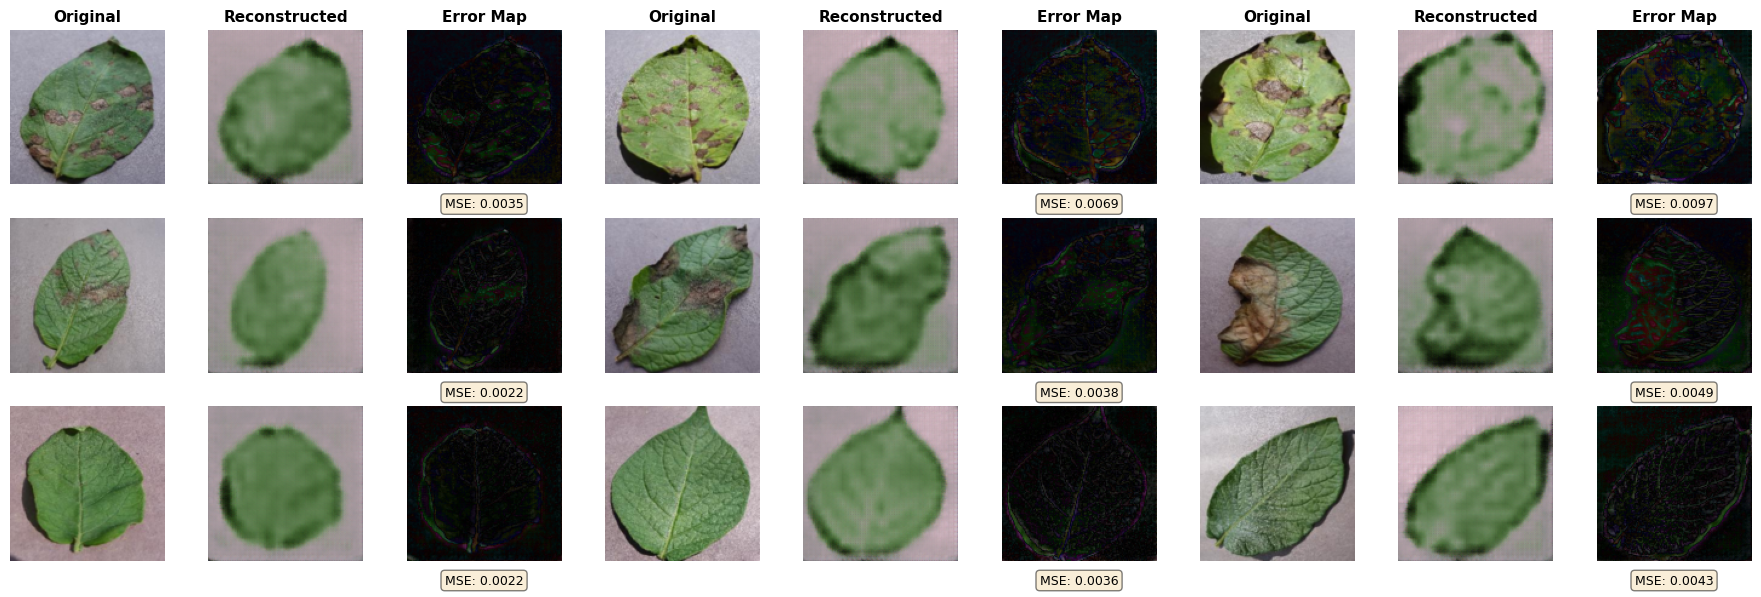

In [11]:
def visualize_reconstructions(results, class_names, n_samples=3):
    """
    Visualisasi contoh rekonstruksi untuk setiap kelas
    """
    errors = results['errors']
    labels = results['labels']
    images = results['images']
    reconstructed = results['reconstructed']
    
    fig, axes = plt.subplots(len(class_names), n_samples * 3, 
                            figsize=(n_samples * 6, len(class_names) * 2))
    
    for class_idx, class_name in enumerate(class_names):
        # Ambil indices untuk kelas ini
        class_indices = np.where(labels == class_idx)[0]
        
        # Pilih samples: beberapa dengan error rendah, beberapa dengan error tinggi
        class_errors = errors[class_indices]
        sorted_indices = class_indices[np.argsort(class_errors)]
        
        # Ambil n_samples samples
        sample_step = len(sorted_indices) // n_samples
        selected_indices = [sorted_indices[i * sample_step] for i in range(n_samples)]
        
        for i, idx in enumerate(selected_indices):
            # Original image
            ax_orig = axes[class_idx, i * 3] if len(class_names) > 1 else axes[i * 3]
            img_orig = images[idx].permute(1, 2, 0).numpy()
            ax_orig.imshow(img_orig)
            ax_orig.axis('off')
            if i == 0:
                ax_orig.set_ylabel(class_name, fontsize=12, fontweight='bold')
            if class_idx == 0:
                ax_orig.set_title('Original', fontsize=11, fontweight='bold')
            
            # Reconstructed image
            ax_recon = axes[class_idx, i * 3 + 1] if len(class_names) > 1 else axes[i * 3 + 1]
            img_recon = reconstructed[idx].permute(1, 2, 0).numpy()
            ax_recon.imshow(img_recon)
            ax_recon.axis('off')
            if class_idx == 0:
                ax_recon.set_title('Reconstructed', fontsize=11, fontweight='bold')
            
            # Difference (error map)
            ax_diff = axes[class_idx, i * 3 + 2] if len(class_names) > 1 else axes[i * 3 + 2]
            diff = np.abs(img_orig - img_recon)
            im = ax_diff.imshow(diff, cmap='hot')
            ax_diff.axis('off')
            if class_idx == 0:
                ax_diff.set_title('Error Map', fontsize=11, fontweight='bold')
            
            # Add error value
            error_val = errors[idx]
            ax_diff.text(0.5, -0.15, f'MSE: {error_val:.4f}', 
                        transform=ax_diff.transAxes, 
                        ha='center', fontsize=9,
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(r'c:\project\project-ai\Autoencoder\model\reconstruction_examples.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

visualize_reconstructions(results, class_names, n_samples=3)

## 12. Perbandingan Detail: Low Error vs High Error

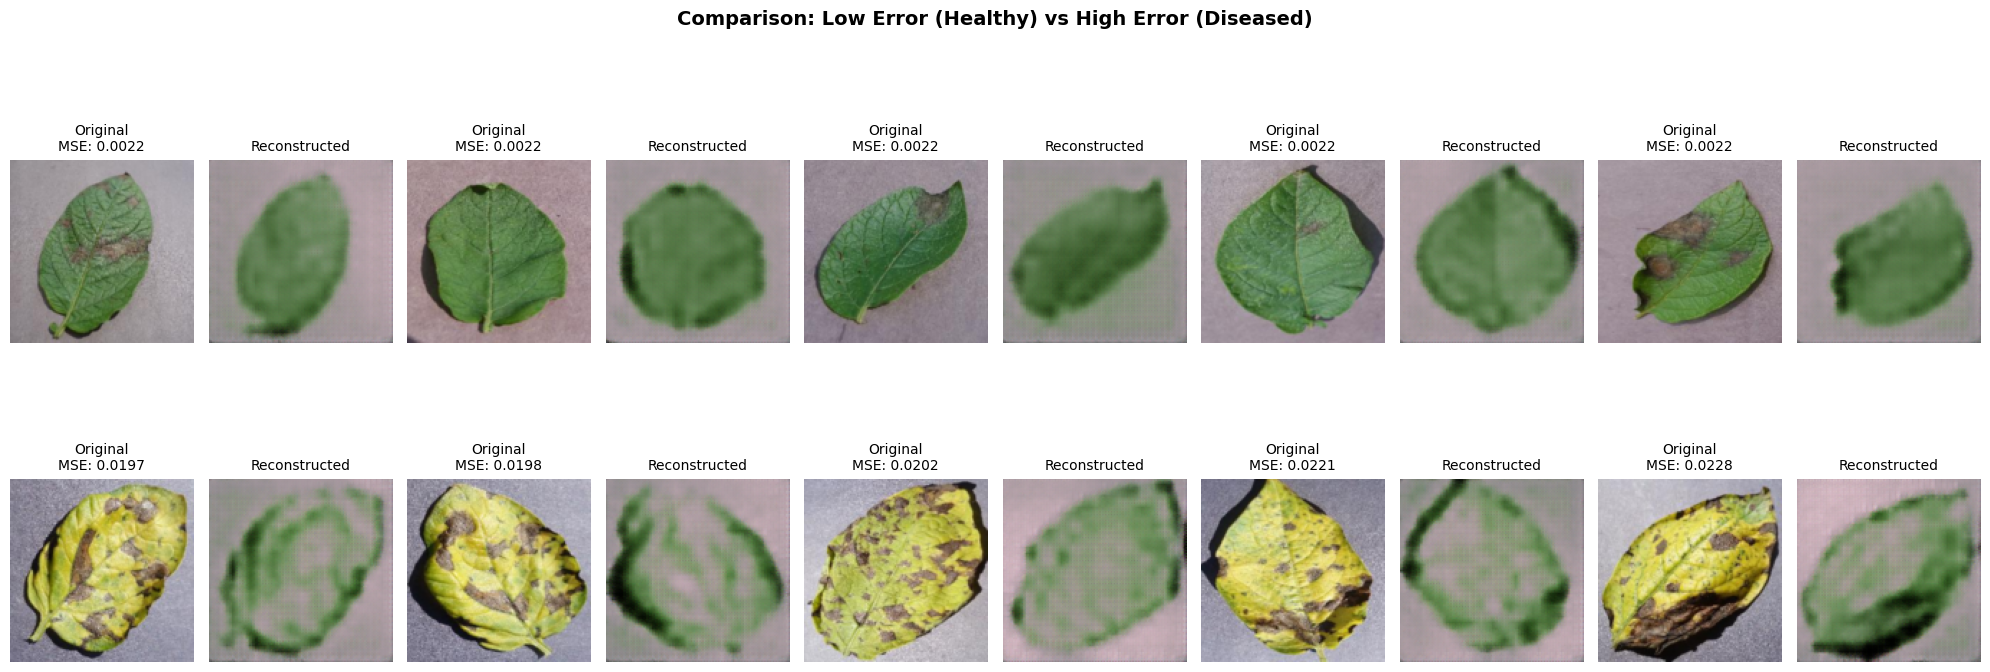

In [12]:
def visualize_low_vs_high_error(results, n_samples=5):
    """
    Visualisasi perbandingan antara gambar dengan error rendah (sehat) 
    dan error tinggi (berpenyakit)
    """
    errors = results['errors']
    labels = results['labels']
    images = results['images']
    reconstructed = results['reconstructed']
    
    # Ambil indices dengan error terendah dan tertinggi
    sorted_indices = np.argsort(errors)
    low_error_indices = sorted_indices[:n_samples]
    high_error_indices = sorted_indices[-n_samples:]
    
    fig, axes = plt.subplots(2, n_samples * 2, figsize=(n_samples * 4, 8))
    
    # Plot low error samples (healthy)
    for i, idx in enumerate(low_error_indices):
        # Original
        img_orig = images[idx].permute(1, 2, 0).numpy()
        axes[0, i * 2].imshow(img_orig)
        axes[0, i * 2].axis('off')
        if i == 0:
            axes[0, i * 2].set_ylabel('LOW ERROR\n(Healthy)', 
                                     fontsize=12, fontweight='bold', color='green')
        axes[0, i * 2].set_title(f'Original\nMSE: {errors[idx]:.4f}', fontsize=10)
        
        # Reconstructed
        img_recon = reconstructed[idx].permute(1, 2, 0).numpy()
        axes[0, i * 2 + 1].imshow(img_recon)
        axes[0, i * 2 + 1].axis('off')
        axes[0, i * 2 + 1].set_title('Reconstructed', fontsize=10)
    
    # Plot high error samples (diseased)
    for i, idx in enumerate(high_error_indices):
        # Original
        img_orig = images[idx].permute(1, 2, 0).numpy()
        axes[1, i * 2].imshow(img_orig)
        axes[1, i * 2].axis('off')
        if i == 0:
            axes[1, i * 2].set_ylabel('HIGH ERROR\n(Diseased)', 
                                     fontsize=12, fontweight='bold', color='red')
        axes[1, i * 2].set_title(f'Original\nMSE: {errors[idx]:.4f}', fontsize=10)
        
        # Reconstructed
        img_recon = reconstructed[idx].permute(1, 2, 0).numpy()
        axes[1, i * 2 + 1].imshow(img_recon)
        axes[1, i * 2 + 1].axis('off')
        axes[1, i * 2 + 1].set_title('Reconstructed', fontsize=10)
    
    plt.suptitle('Comparison: Low Error (Healthy) vs High Error (Diseased)', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(r'c:\project\project-ai\Autoencoder\model\low_vs_high_error.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

visualize_low_vs_high_error(results, n_samples=5)

## 13. Ringkasan Akhir dan Kesimpulan

In [13]:
def print_final_summary(results, class_names, threshold, history):
    """
    Cetak ringkasan akhir dari seluruh eksperimen
    """
    errors = results['errors']
    labels = results['labels']
    
    print("\n" + "="*80)
    print(" " * 20 + "FINAL SUMMARY - AUTOENCODER PROJECT")
    print("="*80)
    
    print("\n### DATASET ###")
    print(f"Classes: {class_names}")
    print(f"Total test images: {len(errors)}")
    for i, class_name in enumerate(class_names):
        count = np.sum(labels == i)
        print(f"  - {class_name}: {count} images")
    
    print("\n### TRAINING ###")
    print(f"Total epochs trained: {len(history['train_loss'])}")
    print(f"Best training loss: {min(history['train_loss']):.6f}")
    print(f"Best validation loss: {min(history['val_loss']):.6f}")
    print(f"Final learning rate: {history['lr'][-1]:.6f}")
    
    print("\n### MODEL ARCHITECTURE ###")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    print("\n### RECONSTRUCTION ERROR STATISTICS ###")
    for i, class_name in enumerate(class_names):
        class_errors = errors[labels == i]
        print(f"{class_name}:")
        print(f"  Mean ± Std: {np.mean(class_errors):.6f} ± {np.std(class_errors):.6f}")
        print(f"  Range: [{np.min(class_errors):.6f}, {np.max(class_errors):.6f}]")
    
    print(f"\n### ANOMALY DETECTION ###")
    print(f"Threshold (mean + 2*std of healthy): {threshold:.6f}")
    
    # Classification metrics
    predictions = (errors > threshold).astype(int)
    ground_truth = (labels != 1).astype(int)  # Asumsi healthy = class 1
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(ground_truth, predictions)
    precision = precision_score(ground_truth, predictions, zero_division=0)
    recall = recall_score(ground_truth, predictions, zero_division=0)
    f1 = f1_score(ground_truth, predictions, zero_division=0)
    
    print(f"\nClassification Performance:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    print("\n### OUTPUT FILES ###")
    print("✓ Model: c:\\project\\project-ai\\Autoencoder\\model\\best_autoencoder.pth")
    print("✓ Training history: c:\\project\\project-ai\\Autoencoder\\model\\training_history.png")
    print("✓ Error distribution: c:\\project\\project-ai\\Autoencoder\\model\\error_distribution.png")
    print("✓ Reconstruction examples: c:\\project\\project-ai\\Autoencoder\\model\\reconstruction_examples.png")
    print("✓ Low vs high error: c:\\project\\project-ai\\Autoencoder\\model\\low_vs_high_error.png")
    
    print("\n" + "="*80)
    print(" " * 30 + "PROJECT COMPLETED!")
    print("="*80 + "\n")

print_final_summary(results, class_names, threshold, history)


                    FINAL SUMMARY - AUTOENCODER PROJECT

### DATASET ###
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Total test images: 2152
  - Potato___Early_blight: 1000 images
  - Potato___Late_blight: 1000 images
  - Potato___healthy: 152 images

### TRAINING ###
Total epochs trained: 200
Best training loss: 0.005153
Best validation loss: 0.004109
Final learning rate: 0.000250

### MODEL ARCHITECTURE ###
Total parameters: 194,755
Trainable parameters: 194,755

### RECONSTRUCTION ERROR STATISTICS ###
Potato___Early_blight:
  Mean ± Std: 0.008940 ± 0.003379
  Range: [0.003459, 0.022803]
Potato___Late_blight:
  Mean ± Std: 0.004483 ± 0.001281
  Range: [0.002184, 0.010008]
Potato___healthy:
  Mean ± Std: 0.004069 ± 0.000810
  Range: [0.002194, 0.006448]

### ANOMALY DETECTION ###
Threshold (mean + 2*std of healthy): 0.007045

Classification Performance:
  Accuracy: 0.7398
  Precision: 0.9458
  Recall: 0.5451
  F1-Score: 0.6916

### OUTPUT FILES ###


## 14. Fungsi Utilitas untuk Prediksi Baru (Optional)

In [14]:
def predict_single_image(image_path, model, threshold, device):
    """
    Prediksi untuk gambar tunggal
    
    Args:
        image_path: Path ke gambar
        model: Model autoencoder yang sudah dilatih
        threshold: Threshold untuk deteksi anomali
        device: Device (cuda/cpu)
    
    Returns:
        Dictionary berisi hasil prediksi
    """
    from PIL import Image
    
    # Load dan preprocess gambar
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Prediksi
    model.eval()
    with torch.no_grad():
        reconstructed = model(image_tensor)
        error = torch.mean((image_tensor - reconstructed) ** 2).item()
    
    # Klasifikasi
    is_anomaly = error > threshold
    prediction = "DISEASED (Anomaly)" if is_anomaly else "HEALTHY (Normal)"
    
    # Visualisasi
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Original
    axes[0].imshow(image_tensor.cpu().squeeze().permute(1, 2, 0))
    axes[0].set_title('Original Image', fontweight='bold')
    axes[0].axis('off')
    
    # Reconstructed
    axes[1].imshow(reconstructed.cpu().squeeze().permute(1, 2, 0))
    axes[1].set_title('Reconstructed Image', fontweight='bold')
    axes[1].axis('off')
    
    # Difference
    diff = torch.abs(image_tensor - reconstructed).cpu().squeeze().permute(1, 2, 0)
    axes[2].imshow(diff, cmap='hot')
    axes[2].set_title('Error Map', fontweight='bold')
    axes[2].axis('off')
    
    fig.suptitle(f'Prediction: {prediction} (MSE: {error:.6f})', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return {
        'error': error,
        'threshold': threshold,
        'is_anomaly': is_anomaly,
        'prediction': prediction
    }

# Contoh penggunaan (uncomment untuk mencoba):
# result = predict_single_image(
#     r"c:\project\project-ai\Autoencoder\dataset\Potato___healthy\0a2175c0-3a0d-4d5b-b3aa-ffea70d6c42e___RS_HL 1755.JPG",
#     model, 
#     threshold, 
#     device
# )
# print(result)

print("Fungsi predict_single_image() siap digunakan!")
print("Uncomment kode di atas untuk mencoba prediksi pada gambar tunggal.")

Fungsi predict_single_image() siap digunakan!
Uncomment kode di atas untuk mencoba prediksi pada gambar tunggal.
